# E18 다양한 OCR 모델 비교하기

In [1]:
#!mkdir -p ~/aiffel/ocr_python
#STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.
#!pip install --upgrade google-api-python-client
#!pip install google-cloud-vision

#STEP 2) Google Cloud Vision API 사용
#!pip install --upgrade google-api-python-client
#!pip install google-cloud-vision
# https://kimchangheon.tistory.com/166

#!pip install pytesseract
#!sudo apt install tesseract-ocr-kor

In [2]:
#STEP 2) Google Cloud Vision API 사용
# https://kimchangheon.tistory.com/166

In [11]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

## Step1. 검증용 데이터셋 준비

In [12]:
work_dir = '/aiffel/aiffel/ocr_python/'

images = glob(work_dir+'*.jpeg')
images.sort()
images

['/aiffel/aiffel/ocr_python/cheetos.jpeg',
 '/aiffel/aiffel/ocr_python/doritos.jpeg',
 '/aiffel/aiffel/ocr_python/nacho.jpeg',
 '/aiffel/aiffel/ocr_python/pinattsu.jpeg',
 '/aiffel/aiffel/ocr_python/pringles.jpeg',
 '/aiffel/aiffel/ocr_python/고구마깡.jpeg',
 '/aiffel/aiffel/ocr_python/허니버터아몬드.jpeg']

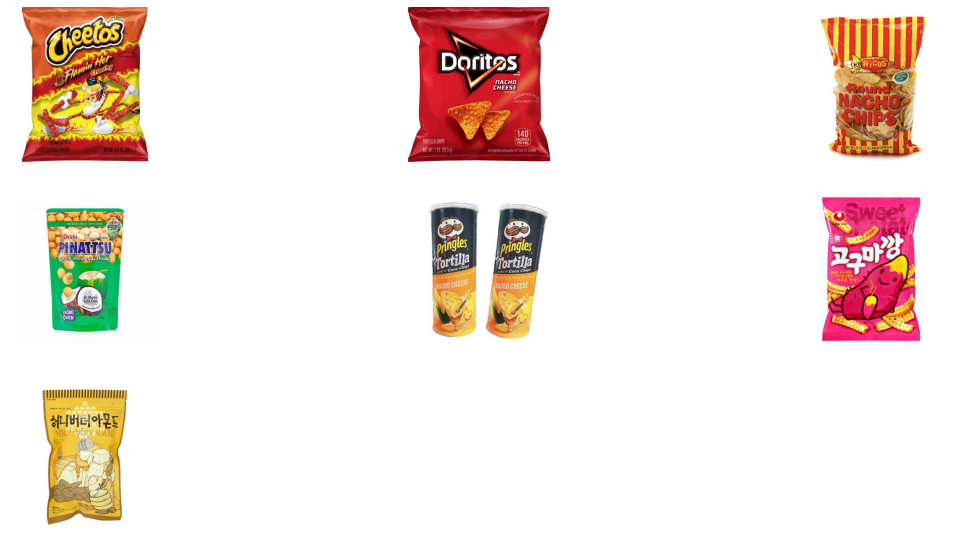

In [13]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

##  Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

In [14]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [16]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


total 360
-rw-r--r-- 1 root root 364827 Dec  3 17:57 E18.ipynb
drwxr-xr-x 2 root root    204 Dec  3 16:10 img


In [17]:
for im in images:
    detect_text(im)

Texts:

"MADE MITN
Ceelos
REAL CHEESE
Flamin Hot
Crundy
FRES
GRARANTE
NTIL ED DATE
CHEESE FLAVORED SNACKS
NET WT. 8% 0Z. (240.9 0)
"

"MADE"

"MITN"

"Ceelos"

"REAL"

"CHEESE"

"Flamin"

"Hot"

"Crundy"

"FRES"

"GRARANTE"

"NTIL"

"ED"

"DATE"

"CHEESE"

"FLAVORED"

"SNACKS"

"NET"

"WT."

"8%"

"0Z."

"(240.9"

"0)"
bounds: (393,440),(404,440),(404,458),(393,458)
Texts:

"Dorites
BRAND
ПАСНО
CHEESE
FLAVORED
FRESH
CUARANTEED FRES
• UNTIL PRINTED DATE
140
CALORIES
PER PKG
TORTILLA CHIPS
See Nutrition Information for Total Fat Content.
NET WT. 1 OZ. (28.3 g)
"

"Dorites"

"BRAND"

"ПАСНО"

"CHEESE"

"FLAVORED"

"FRESH"

"CUARANTEED"

"FRES"

"•"

"UNTIL"

"PRINTED"

"DATE"

"140"

"CALORIES"

"PER"

"PKG"

"TORTILLA"

"CHIPS"

"See"

"Nutrition"

"Information"

"for"

"Total"

"Fat"

"Content."

"NET"

"WT."

"1"

"OZ."

"(28.3"

"g)"
bounds: (467,1361),(487,1361),(486,1408),(466,1408)
Texts:

"(RICOS
Ope mators of Concessin Noehos
Og TRANSTAT
CHOLESTEROL
FREE
Round
NACHO
CHIPS
NET WT.

## Keras-ocr

In [19]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [20]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


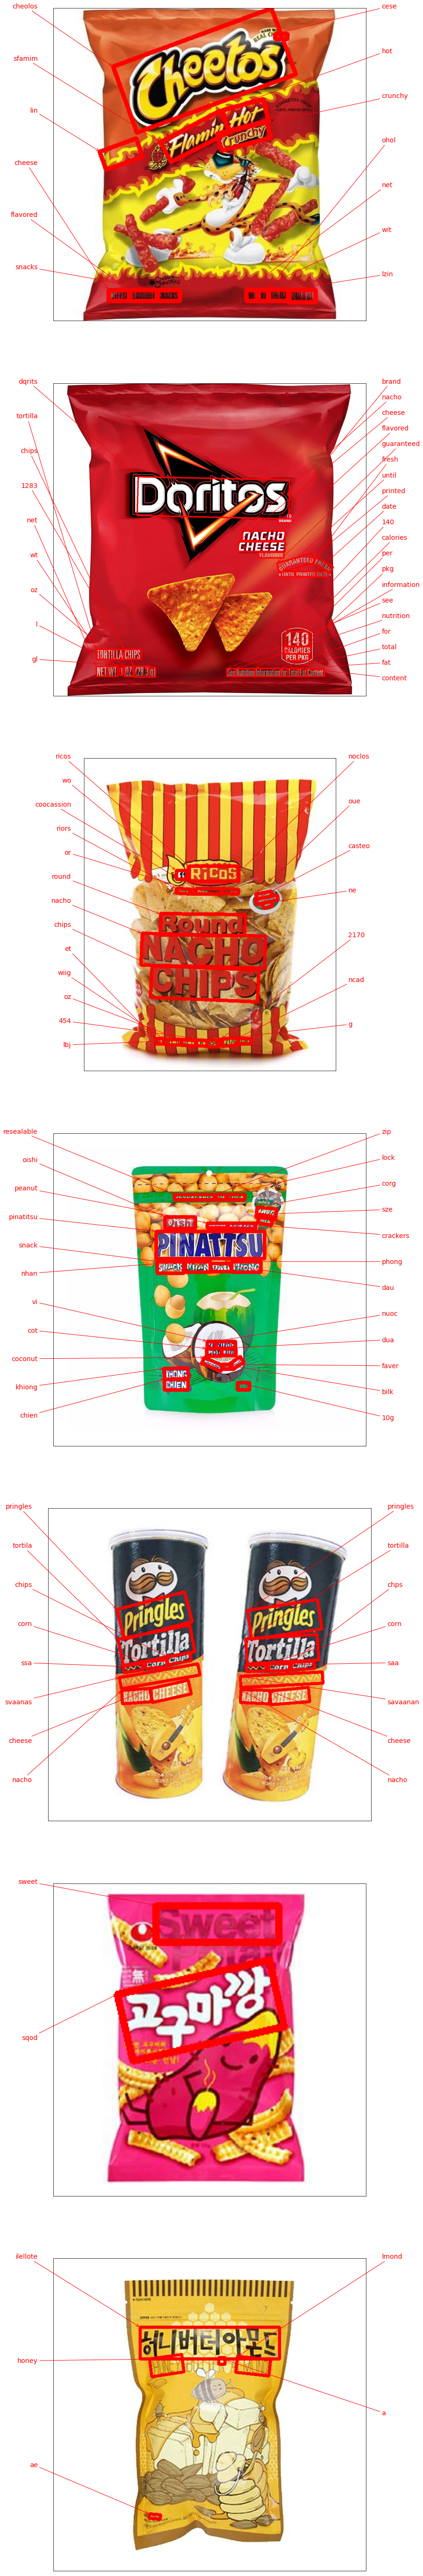

In [21]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [22]:
def crop_word_regions(idx, image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list



In [27]:
cropped_image_path_list = images

In [28]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(  #검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나온다.
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

7 | ‘



t ey


é

BI ;

Done


In [35]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images_kor(cropped_image_path_list)

|  쳐 |  는



【  떠

 -

[3

1)   |

Done


##  Step3. 테스트 결과 정리

(-0.5, 487.5, 487.5, -0.5)

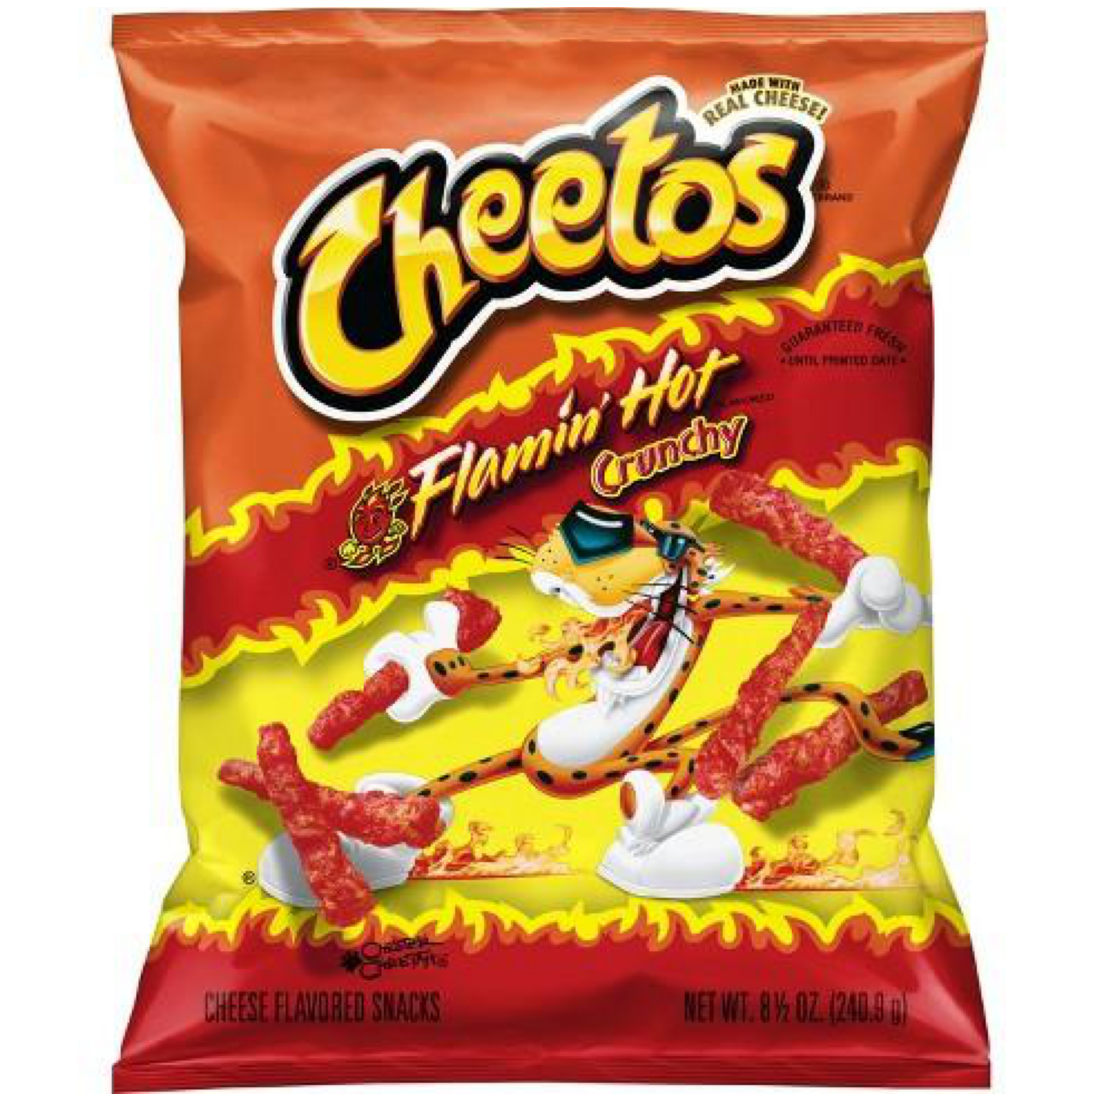

In [37]:
plt.figure(figsize=(20,20))
im = img.imread(images[0])
plt.imshow(im)
plt.axis('off')

##  Step4. 결과 분석과 결론 제시

### Tesseract

In [40]:
recognize_images(cropped_image_path_list)

7 | ‘



t ey


é

BI ;

Done


### keras_ocr

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

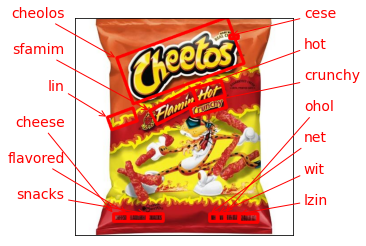

In [42]:
keras_ocr.tools.drawAnnotations(image=images_keras_ocr[0], 
                                    predictions=prediction_groups[0][0])


### Google OCR API

In [43]:
detect_text(images[0])

Texts:

"MADE MITN
Ceelos
REAL CHEESE
Flamin Hot
Crundy
FRES
GRARANTE
NTIL ED DATE
CHEESE FLAVORED SNACKS
NET WT. 8% 0Z. (240.9 0)
"

"MADE"

"MITN"

"Ceelos"

"REAL"

"CHEESE"

"Flamin"

"Hot"

"Crundy"

"FRES"

"GRARANTE"

"NTIL"

"ED"

"DATE"

"CHEESE"

"FLAVORED"

"SNACKS"

"NET"

"WT."

"8%"

"0Z."

"(240.9"

"0)"
bounds: (393,440),(404,440),(404,458),(393,458)


##  Step5. 회고
- OCR을 활용하여 구현하려는 서비스의 기획
- 모델 평가기준 세우기
- 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과정리